<a href="https://colab.research.google.com/github/wentianma/House-Price-Forecast/blob/master/house_price_eda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

House Price Forecast Project Workflow
1. Define business object
2. Data Exploratory Analysis
   * Univariate
   * Multi-Variate
3. Correlation analysis (pair-wise and attribute combinations)
4. Data cleaning (missing data, outliers, data errors)
   * missing data: fill train dataset with median, and fill test dataset with 0
   * delete some outliers
   * convert some numerical variables to categorical data type (year and month)
5. Data transformation via pipelines (categorical text to number using one hot encoding, feature scaling via normalization/standardization, feature combinations)
  * convert categorical variables using labelencoder( )
  * log-normality for skewed variables
  * robustscaler (sensitive to outliers)
  * feature combinations: combine some variables into one (like garage and basement variables)
6. Train and cross validate 14 models
  * calculated rmse score
  * hyperparameter tuning by GridSerach
  * ensemble learning first stacking meta model
  * ensemble learning second tier stacking meta model with lgboost and xgboost (good for outliers)
7. Evaluate the model with best estimators in the test set

1. Define business object
  * Aim: to forecast the house price in test.csv
  * Target variable: sale price
  * Input variables: 79 variables including sale price in train.csv; 78 variables without sale price in test.csv

In [0]:
url = 'https://raw.githubusercontent.com/wentianma/House-Price-Forecast/master/train.csv'
train = pd.read_csv(url)
url1 = 'https://raw.githubusercontent.com/wentianma/House-Price-Forecast/master/test.csv'
test = pd.read_csv(url1)

In [0]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
plt.style.use('ggplot')

In [0]:
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline, make_pipeline
from scipy.stats import skew,norm
from sklearn.decomposition import PCA, KernelPCA
from sklearn.preprocessing import Imputer

In [0]:
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, cross_val_predict
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import scale
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet, SGDRegressor, BayesianRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.svm import SVR, LinearSVR
import lightgbm as lgb
from sklearn.kernel_ridge import KernelRidge
from xgboost import XGBRegressor

2. Data Exploratory Analysis

In [48]:
train

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
5,6,50,RL,85.0,14115,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,MnPrv,Shed,700,10,2009,WD,Normal,143000
6,7,20,RL,75.0,10084,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,307000
7,8,60,RL,NaN,10382,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,Shed,350,11,2009,WD,Normal,200000
8,9,50,RM,51.0,6120,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2008,WD,Abnorml,129900
9,10,190,RL,50.0,7420,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,1,2008,WD,Normal,118000


In [49]:
train.dtypes

Id                 int64
MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
Street            object
Alley             object
LotShape          object
LandContour       object
Utilities         object
LotConfig         object
LandSlope         object
Neighborhood      object
Condition1        object
Condition2        object
BldgType          object
HouseStyle        object
OverallQual        int64
OverallCond        int64
YearBuilt          int64
YearRemodAdd       int64
RoofStyle         object
RoofMatl          object
Exterior1st       object
Exterior2nd       object
MasVnrType        object
MasVnrArea       float64
ExterQual         object
ExterCond         object
Foundation        object
                  ...   
BedroomAbvGr       int64
KitchenAbvGr       int64
KitchenQual       object
TotRmsAbvGrd       int64
Functional        object
Fireplaces         int64
FireplaceQu       object
GarageType        object
GarageYrBlt      float64


In order to better analyzing data, I will combine train and test dataset. Since there may miss a lot of data and may miss different variable value between train and test dataset. I will be very careful dealing with test dataset in data cleaning and data transformation parts.

2.1 Univariate 'SalePrice'

In [50]:
train['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

There is no missing value for Sale Price and data type is numerical.

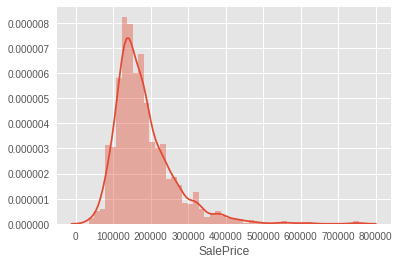

In [51]:
sns.distplot(train['SalePrice'])

In [52]:
#skewness and kurtosis
print("Skewness: %f" % train['SalePrice'].skew())
print("Kurtosis: %f" % train['SalePrice'].kurt())

Skewness: 1.882876
Kurtosis: 6.536282


* Peak Kurtosis  > 3 (normal distribution kurtosis). 
Positive skewness > 1 (normal distribution skewness).

2.2 Multi-Variate Analysis

In [53]:
train.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


3. Correlation analysis (pair-wise and attribute combinations)

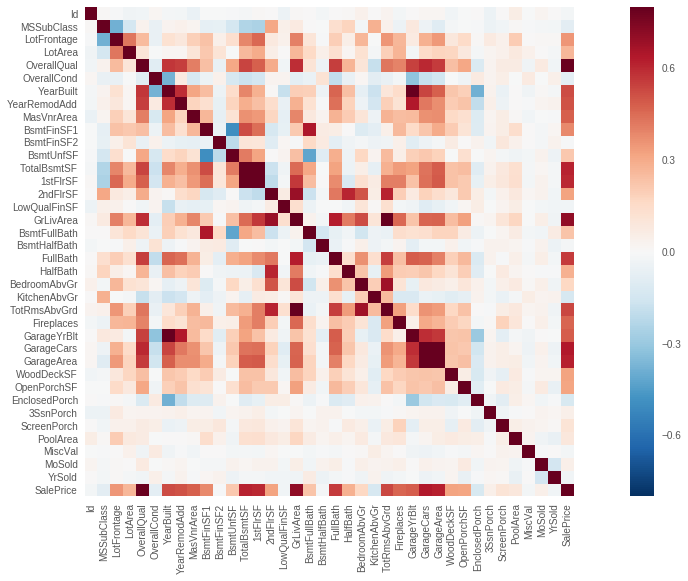

In [54]:
corrmat = train.corr()
f, ax = plt.subplots(figsize=(20, 9))
sns.heatmap(corrmat, vmax=0.8, square=True)

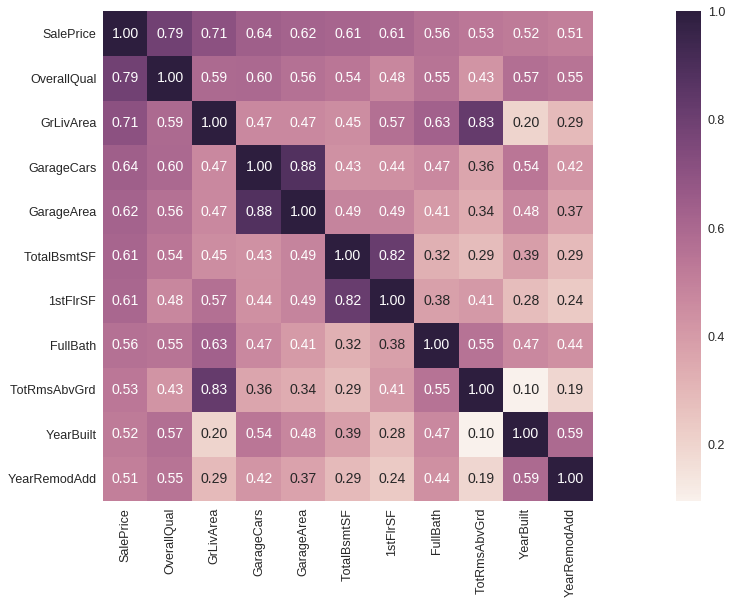

In [55]:
k = 11
cols = train.corr().nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(train[cols].values.T)
sns.set(font_scale = 1.25)
plt.figure(figsize = (30,9))
hm = sns.heatmap(cm, cbar=True, annot=True, \
                 square=True, fmt='.2f', annot_kws={'size': 14}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

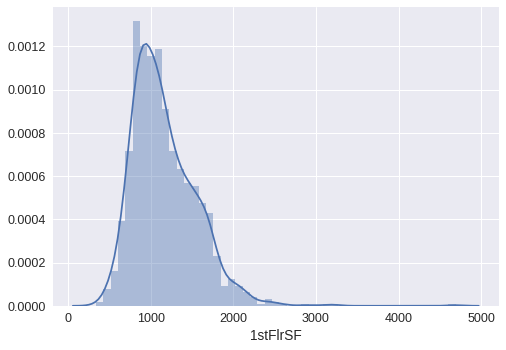

In [56]:
sns.distplot(train['1stFlrSF'])

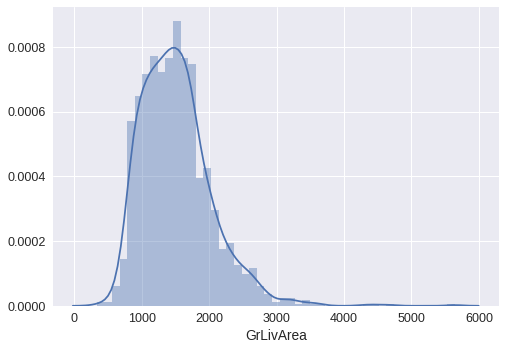

In [57]:
sns.distplot(train['GrLivArea'])

Seems like there are some numerical variables also have positive skews. Will do logistic algorithms for those variables later.

4. Data cleaning (outliers,  data errors, missing data)
  * 4.1 outliers

(0, 800000)

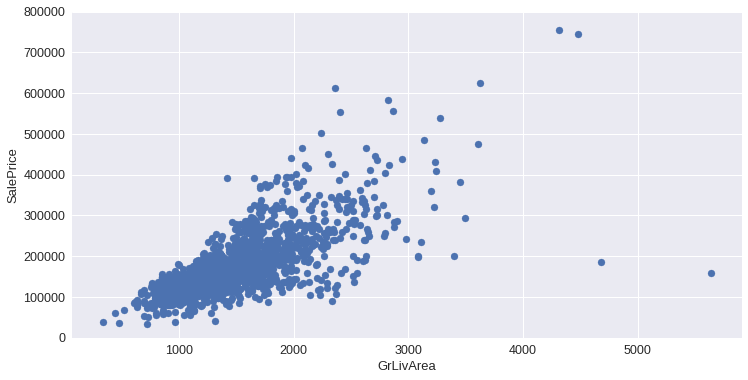

In [58]:
plt.figure(figsize=(12,6))
plt.scatter(x=train.GrLivArea, y=train.SalePrice)
plt.xlabel("GrLivArea", fontsize=13)
plt.ylabel("SalePrice", fontsize=13)
plt.ylim(0,800000)

The bottom right two points with very large GrLivArea seem like outliers to me (might be large arigucultural land). Also since they are not in the line regression cluster, I will delete them.

In [0]:
train.drop(train[(train["GrLivArea"]>4000)&(train["SalePrice"]<300000)].index,inplace=True)

Text(0, 0.5, 'SalePrice')

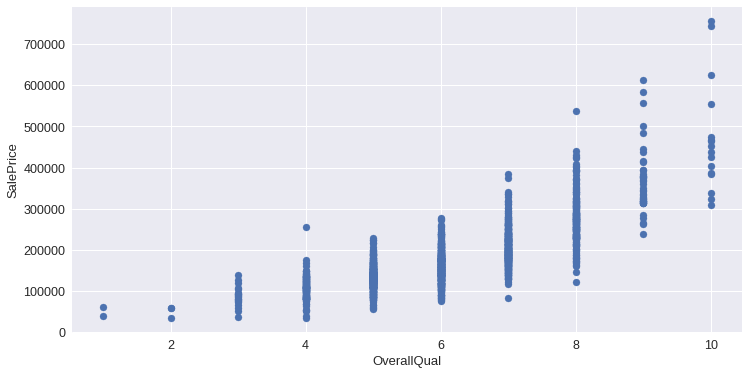

In [60]:
plt.figure(figsize=(12,6))
plt.scatter(x=train.OverallQual, y=train.SalePrice)
plt.xlabel("OverallQual", fontsize=13)
plt.ylabel("SalePrice", fontsize=13)

In [0]:
train.drop(train[(train['OverallQual']<5) & (train['SalePrice']>200000)].index, inplace=True)

In [62]:
full=pd.concat([train,test], ignore_index=True)
full.drop(['Id'],axis=1, inplace=True)
full.shape

(2916, 80)

4.2 data error

In [0]:
# Some of the non-numeric predictors are stored as numbers; we convert them into strings 
full['MSSubClass'] = full['MSSubClass'].apply(str)
full['YrSold'] = full['YrSold'].astype(str)
full['MoSold'] = full['MoSold'].astype(str)

  * 4.3 Missing Data
   * Here I will spend lots of time on missing data. I will go over with overall missing variables. Then fill missing variables from the most to least. Some categorical features will be transform to dummy variables and some will be deleted. Some numerical will be fill with median or 0. 

In [64]:
# missing data
total = full.isnull().sum()
total = total[total>0]
percent = (full.isnull().sum()/full.isnull().count())
percent = percent[percent>0]
dtypes = full.dtypes
nulls = np.sum(full.isnull())
dtypes2 = dtypes.loc[(nulls != 0)]
missing_data = pd.concat([total,percent,dtypes2], axis = 1).sort_values(by=0,ascending=False)
missing_data

,0,1,2
PoolQC,2907,0.996914,object
MiscFeature,2811,0.963992,object
Alley,2718,0.932099,object
Fence,2345,0.804184,object
SalePrice,1459,0.500343,float64
FireplaceQu,1420,0.486968,object
LotFrontage,485,0.166324,float64
GarageFinish,159,0.054527,object
GarageQual,159,0.054527,object
GarageYrBlt,159,0.054527,float64


In [0]:
# Before getting hands dirty with missing values, I will creat dummy variables for all non-missing categorical features.
full_missing_col = [col for col in full.columns if full[col].isnull().any()]                                  
full_predictors = full.drop(full_missing_col, axis=1)

In [66]:
full_category_cols= [cname for cname in full_predictors.columns if 
full_predictors[cname].dtype == "object"]
full_category_cols

['BldgType',
 'CentralAir',
 'Condition1',
 'Condition2',
 'ExterCond',
 'ExterQual',
 'Foundation',
 'Heating',
 'HeatingQC',
 'HouseStyle',
 'LandContour',
 'LandSlope',
 'LotConfig',
 'LotShape',
 'MSSubClass',
 'MoSold',
 'Neighborhood',
 'PavedDrive',
 'RoofMatl',
 'RoofStyle',
 'SaleCondition',
 'Street',
 'YrSold']

In [67]:
# create numerical columns list for future use.
full_num_cols= [cname for cname in full.columns if full[cname].dtype != "object"]
full_num_cols

['1stFlrSF',
 '2ndFlrSF',
 '3SsnPorch',
 'BedroomAbvGr',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtFullBath',
 'BsmtHalfBath',
 'BsmtUnfSF',
 'EnclosedPorch',
 'Fireplaces',
 'FullBath',
 'GarageArea',
 'GarageCars',
 'GarageYrBlt',
 'GrLivArea',
 'HalfBath',
 'KitchenAbvGr',
 'LotArea',
 'LotFrontage',
 'LowQualFinSF',
 'MasVnrArea',
 'MiscVal',
 'OpenPorchSF',
 'OverallCond',
 'OverallQual',
 'PoolArea',
 'SalePrice',
 'ScreenPorch',
 'TotRmsAbvGrd',
 'TotalBsmtSF',
 'WoodDeckSF',
 'YearBuilt',
 'YearRemodAdd']

In [0]:
full = pd.get_dummies(full,columns=full_category_cols)

It is nice to know in which features miss values in both train and test dataset. I will only fill missing data in the train dataset with "None" or "0", then using get_dummy, without changing test data value.

In [0]:
for col in ("PoolQC", "MiscFeature", "Alley", "Fence", "FireplaceQu",
           "GarageType", "GarageFinish", "GarageQual", "GarageCond",
           "BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1",
            "BsmtFinType2", "MasVnrType"):
    full[col] = full[col].fillna("None")

In [0]:
for col in ("GarageArea", "GarageCars", "BsmtFinSF1", 
           "BsmtFinSF2", "BsmtUnfSF", "TotalBsmtSF", "MasVnrArea",
           "BsmtFullBath", "BsmtHalfBath"):
    full[col] = full[col].fillna(0)

Firstly,  "LotFrontage"is missing 14% values. I will fill with the median value group by LotAreaCut. Here I will fill separately in train and test dataset.

In [71]:
train.groupby(['Neighborhood'])[['LotFrontage']].agg(['mean','median','count'])

LotFrontage             
                    mean median count
Neighborhood                         
Blmngtn        47.142857   43.0    14
Blueste        24.000000   24.0     2
BrDale         21.562500   21.0    16
BrkSide        57.509804   52.0    51
ClearCr        83.461538   80.0    13
CollgCr        71.682540   70.0   126
Crawfor        71.804878   74.0    41
Edwards        64.811111   64.5    90
Gilbert        79.877551   65.0    49
IDOTRR         62.500000   60.0    34
MeadowV        27.800000   21.0    15
Mitchel        70.083333   73.0    36
NAmes          76.462366   73.0   186
NPkVill        32.285714   24.0     7
NWAmes         81.288889   80.0    45
NoRidge        91.878788   91.0    33
NridgHt        81.881579   88.5    76
OldTown        62.788991   60.0   109
SWISU          58.913043   60.0    23
Sawyer         74.437500   71.0    48
SawyerW        71.500000   66.5    50
Somerst        64.666667   73.5    78
StoneBr        62.700000   61.5    20
Timber         80.133333   85.0    30
Veenker        59.714286   68.0     7

In [0]:
train["LotFrontage"] = train.groupby(["Neighborhood"])[["LotFrontage"]].transform(lambda x: x.fillna(x.median())) 
test["LotFrontage"] =  test.groupby(["Neighborhood"])[['LotFrontage']].transform(lambda x: x.fillna(x.median()))
full["LotFrontage"] = pd.concat([train["LotFrontage"],test["LotFrontage"]],axis =0,ignore_index=True)

In [73]:
test["LotFrontage"].describe()

count    1459.000000
mean       68.955106
std        20.999091
min        21.000000
25%        60.000000
50%        70.000000
75%        80.000000
max       200.000000
Name: LotFrontage, dtype: float64

In [74]:
full["LotFrontage"].describe()

count    2916.000000
mean       69.467078
std        21.241330
min        21.000000
25%        60.000000
50%        70.000000
75%        80.000000
max       313.000000
Name: LotFrontage, dtype: float64

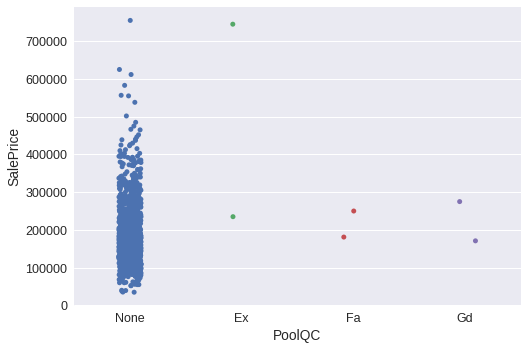

In [75]:
sns.stripplot(x="PoolQC", y="SalePrice", data=full, size = 5, jitter = True)

PoolQC is missing 99% data  and it doesn't show any relation with sale price. Therefore, I will delete PoolQC.

In [0]:
full.drop('PoolQC', axis=1, inplace=True)

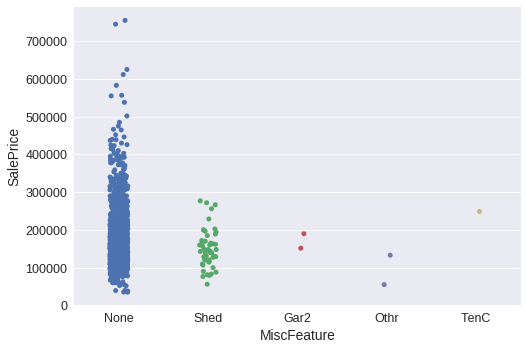

In [77]:
sns.stripplot(x="MiscFeature", y="SalePrice", data=full, size = 5, jitter = True)

In [0]:
# There are only a low number of houses in this area with any miscalleanous features.
full.drop(['MiscFeature'],axis=1, inplace=True)

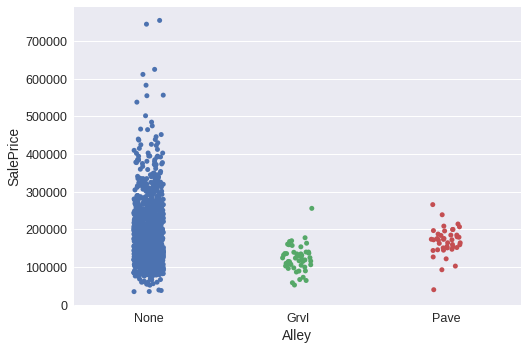

In [79]:
sns.stripplot(x="Alley", y="SalePrice", data=full, size = 5, jitter = True)

In [80]:
full['Alley'] = full['Alley'].map({"None":0, "Grvl":1, "Pave":2})
full.head(3)

,1stFlrSF,2ndFlrSF,3SsnPorch,Alley,BedroomAbvGr,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,BsmtFinType1,...,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,Street_Grvl,Street_Pave,YrSold_2006,YrSold_2007,YrSold_2008,YrSold_2009,YrSold_2010
0,856,854,0,0,3,TA,No,706.0,0.0,GLQ,...,0,1,0,0,1,0,0,1,0,0
1,1262,0,0,0,3,TA,Gd,978.0,0.0,ALQ,...,0,1,0,0,1,0,1,0,0,0
2,920,866,0,0,3,TA,Mn,486.0,0.0,GLQ,...,0,1,0,0,1,0,0,1,0,0


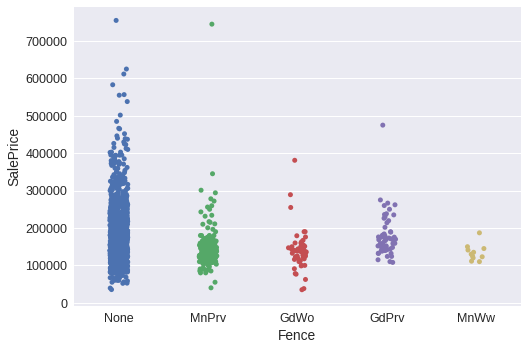

In [81]:
sns.stripplot(x="Fence", y="SalePrice", data=full, size = 5, jitter = True)

In [82]:
full['Fence'] = full['Fence'].map({"None":0, "MnWw":1, "MnPrv":2, "GdPrv":3, "GdWo":4})
full.head(3)

,1stFlrSF,2ndFlrSF,3SsnPorch,Alley,BedroomAbvGr,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,BsmtFinType1,...,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,Street_Grvl,Street_Pave,YrSold_2006,YrSold_2007,YrSold_2008,YrSold_2009,YrSold_2010
0,856,854,0,0,3,TA,No,706.0,0.0,GLQ,...,0,1,0,0,1,0,0,1,0,0
1,1262,0,0,0,3,TA,Gd,978.0,0.0,ALQ,...,0,1,0,0,1,0,1,0,0,0
2,920,866,0,0,3,TA,Mn,486.0,0.0,GLQ,...,0,1,0,0,1,0,0,1,0,0


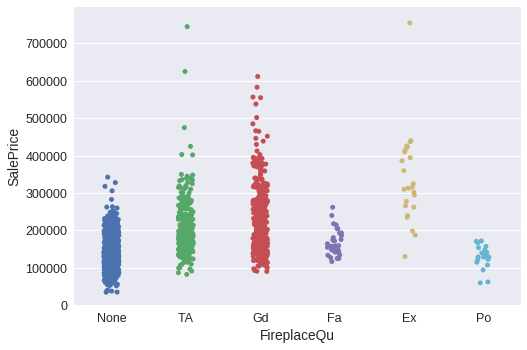

In [83]:
sns.stripplot(x="FireplaceQu", y="SalePrice", data=full, size = 5, jitter = True)

In [84]:
# this is a categorical feature with order, I will replace the values by hand.
full['FireplaceQu'] = full['FireplaceQu'].map({"None":0, "Po":1, "Fa":2, "TA":3, "Gd":4, "Ex":5})
full['FireplaceQu'].unique()

array([0, 3, 4, 2, 5, 1])

Next, I will deal with garage related variables.
  * GarageCond, GarageQual, GarageFinish, and GarageType

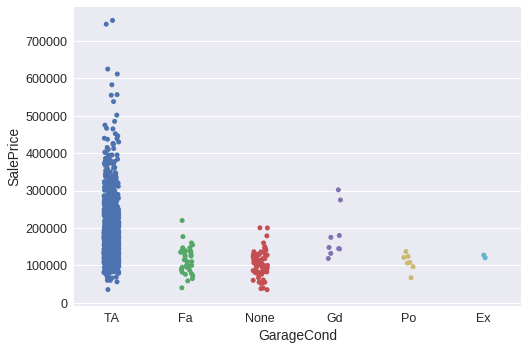

In [85]:
sns.stripplot(x="GarageCond", y="SalePrice", data=full, size = 5, jitter = True)

In [0]:
full['GarageCond'] = full['GarageCond'].map({"None":0, "Po":1, "Fa":2, "TA":3, "Gd":4, "Ex":5})

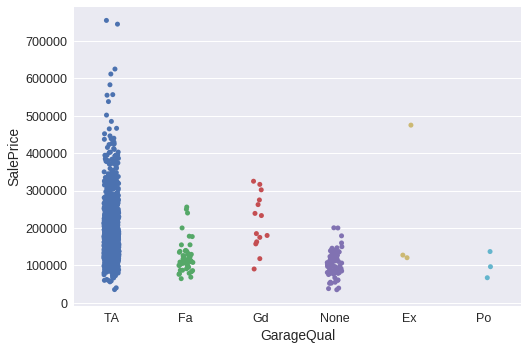

In [87]:
sns.stripplot(x="GarageQual", y="SalePrice", data=full, size = 5, jitter = True)

In [0]:
full['GarageQual'] = full['GarageQual'].map({"None":0, "Po":1, "Fa":2, "TA":3, "Gd":4, "Ex":5})

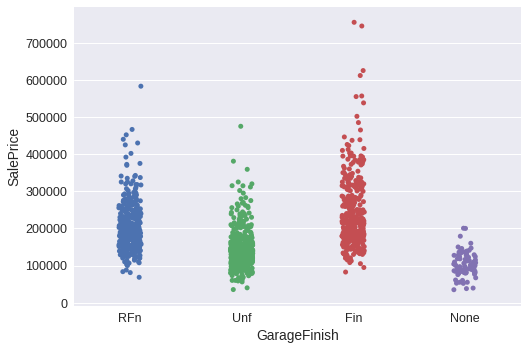

In [89]:
sns.stripplot(x="GarageFinish", y="SalePrice", data=full, size = 5, jitter = True)

In [0]:
full['GarageFinish'] = full['GarageFinish'].map({"None":0, "Unf":1, "RFn":2, "Fin":3})

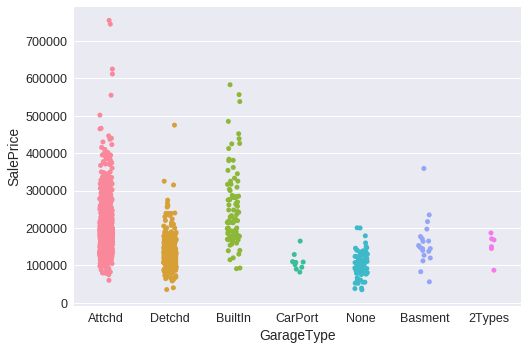

In [91]:
sns.stripplot(x="GarageType", y="SalePrice", data=full, size = 5, jitter = True)

In [0]:
full['GarageType'] = full['GarageType'].map({"None":0,"2Types":1,"Attchd":2,"Basment":3,"BuiltIn":4,"CarPort":5,"Detchd":6})

Basement related variables: BsmtExposure, BsmtCond, BsmtQual, BsmtFinType2, BsmtFinType1

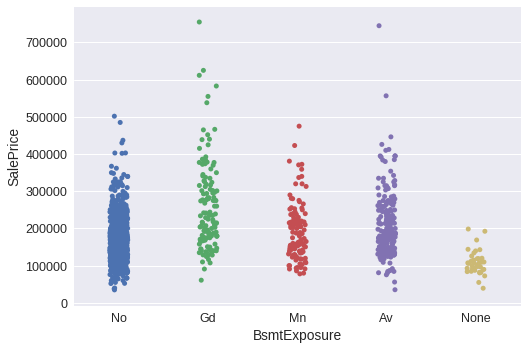

In [93]:
sns.stripplot(x="BsmtExposure", y="SalePrice", data=full, size = 5, jitter = True)

In [0]:
full['BsmtExposure'] = full['BsmtExposure'].map({"None":0, "No":1, "Mn":2, "Av":3, "Gd":4})

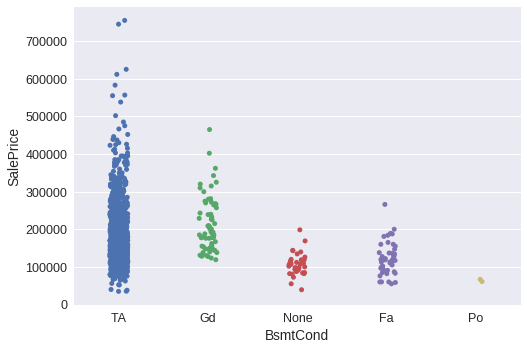

In [95]:
sns.stripplot(x="BsmtCond", y="SalePrice", data=full, size = 5, jitter = True)

In [0]:
full['BsmtCond'] = full['BsmtCond'].map({"None":0, "Po":1, "Fa":2, "TA":3, "Gd":4, "Ex":5})

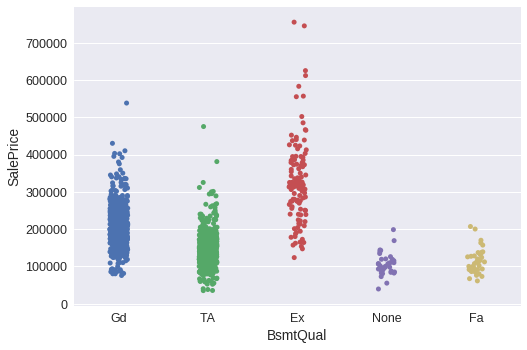

In [97]:
sns.stripplot(x="BsmtQual", y="SalePrice", data=full, size = 5, jitter = True)

In [0]:
full['BsmtQual'] = full['BsmtQual'].map({"None":0, "Fa":1, "TA":2, "Gd":3, "Ex":4})

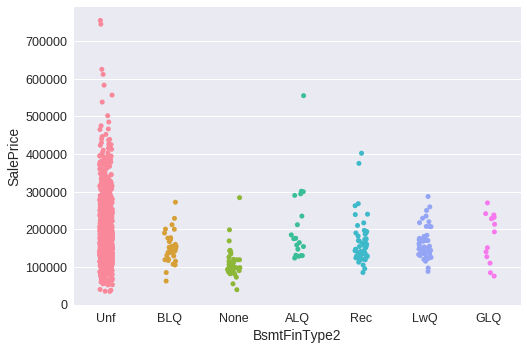

In [99]:
sns.stripplot(x="BsmtFinType2", y="SalePrice", data=full, size = 5, jitter = True)

In [0]:
full['BsmtFinType2'] = full['BsmtFinType2'].map({"None":0, "Unf":1, "LwQ":2, "Rec":3, "BLQ":4, "ALQ":5,"GLQ":6})

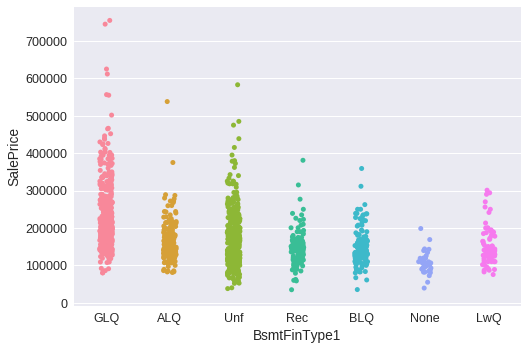

In [101]:
sns.stripplot(x="BsmtFinType1", y="SalePrice", data=full, size = 5, jitter = True)

In [0]:
full['BsmtFinType1'] = full['BsmtFinType1'].map({"None":0, "Unf":1, "LwQ":2, "Rec":3, "BLQ":4, "ALQ":5,"GLQ":6})

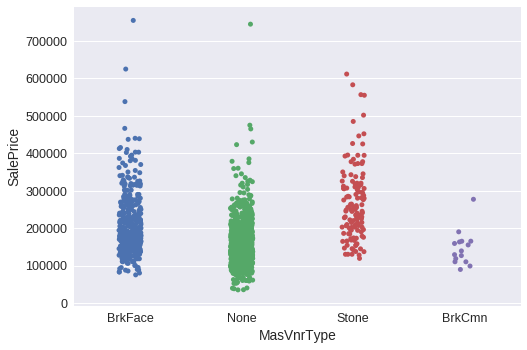

In [103]:
sns.stripplot(x="MasVnrType", y="SalePrice", data=full, size = 5, jitter = True)

In [0]:
full = pd.get_dummies(full, columns = ["MasVnrType"], prefix="MasVnrType")

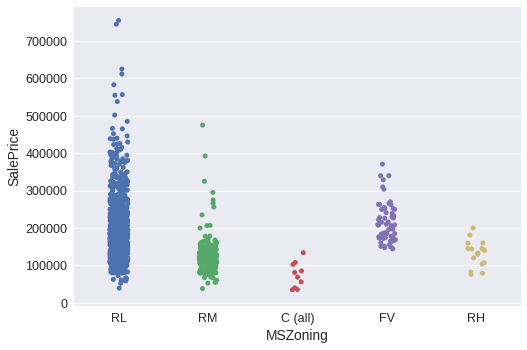

In [105]:
sns.stripplot(x="MSZoning", y="SalePrice", data=full, size = 5, jitter = True)

In [0]:
full = pd.get_dummies(full, columns = ["MSZoning"], prefix="MSZoning")

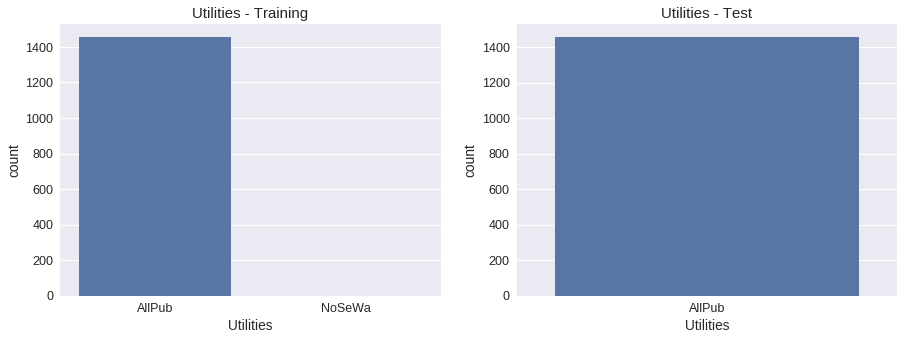

In [107]:
plt.subplots(figsize =(15, 5))
plt.subplot(1, 2, 1)
g = sns.countplot(x = "Utilities", data = train).set_title("Utilities - Training")
plt.subplot(1, 2, 2)
g = sns.countplot(x = "Utilities", data = test).set_title("Utilities - Test")

In [0]:
# Since there is only one category for Utilities feature, therefore I will drop this feature.
full = full.drop(['Utilities'], axis=1)

In [0]:
# 'GarageYrBlt' is missing 164 values. I assume 'GarageYrBlt' equal to YearBuilt time.Thus these two columns will be highly correlated. Therefore, I delete the 'GarageYrBlt'.
full['GarageYrBlt'] = full['GarageYrBlt'].fillna(full['YearBuilt'])

In [0]:
for col in ( "GarageArea", "GarageCars", "BsmtFinSF1", 
           "BsmtFinSF2", "BsmtUnfSF", "TotalBsmtSF", "MasVnrArea",
           "BsmtFullBath", "BsmtHalfBath"):
    full[col] = full[col].fillna(0)

In [0]:
full['Electrical'] = full['Electrical'].fillna(full['Electrical'].mode()[0])
full['KitchenQual'] = full['KitchenQual'].fillna(full['KitchenQual'].mode()[0])
full['Exterior1st'] = full['Exterior1st'].fillna(full['Exterior1st'].mode()[0])
full['Exterior2nd'] = full['Exterior2nd'].fillna(full['Exterior2nd'].mode()[0])
full['SaleType'] = full['SaleType'].fillna(full['SaleType'].mode()[0])
full["Functional"] = full["Functional"].fillna(full['Functional'].mode()[0])
full = pd.get_dummies(full,columns=['Electrical','KitchenQual','Exterior1st','Exterior2nd','SaleType',"Functional"])

In [112]:
# check missing data again
total = full.isnull().sum()
total = total[total>0]
percent = (full.isnull().sum()/full.isnull().count())
percent = percent[percent>0]
dtypes = full.dtypes
nulls = np.sum(full.isnull())
dtypes2 = dtypes.loc[(nulls != 0)]
missing_data = pd.concat([total,percent,dtypes2], axis = 1).sort_values(by=0,ascending=False)
missing_data

,0,1,2
SalePrice,1459,0.500343,float64


Great, there is no missing value, except the SalePrice variable in test dataset.

5. Data transformation via pipelines
Feature Engineering
  * 5.1 Convert some numerical variables into categorical variables: LabelEncoder and dummy variables. (Already did during missing value filling)
  * 5.2 Run Box-Cox transformation for skewed numercial variables
  * 5.3 Perform RobustScaler() to better fit outlier values
  * 5.4 PCA (doesn't work well)

In [0]:
# Adding total sqfootage feature 
full['TotalSF'] = full['TotalBsmtSF'] + full['1stFlrSF'] + full['2ndFlrSF']

In [0]:
# Check skewness for all numerical variables
skew_features = full[full_num_cols + ['TotalSF']].apply(lambda x: skew(x)).sort_values(ascending=False)
skews = pd.DataFrame({'skew':skew_features})

In [115]:
# Box-Cox Transformation
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

high_skew = skew_features[abs(skew_features) > 0.75]
skew_index = high_skew.index

for i in skew_index:
    full[i]= boxcox1p(full[i], boxcox_normmax(full[i]+1))

skew_features2 = full[full_num_cols].apply(lambda x: skew(x)).sort_values(ascending=False)
skews2 = pd.DataFrame({'skew':skew_features2})
skews2

,skew
PoolArea,15.592364
3SsnPorch,8.860495
LowQualFinSF,8.491121
MiscVal,5.237026
BsmtHalfBath,3.778671
KitchenAbvGr,3.777556
ScreenPorch,3.151991
BsmtFinSF2,2.577759
EnclosedPorch,2.148620
MasVnrArea,0.977229


Text(0.5, 0, 'Log SalePrice')

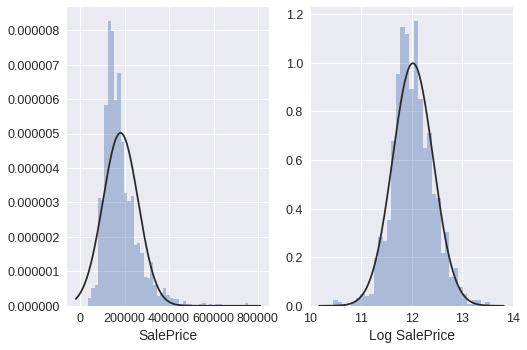

In [116]:
# logistic for SalePrice
plt.subplot(1, 2, 1)
sns.distplot(train.SalePrice, kde=False, fit = norm)

plt.subplot(1, 2, 2)
sns.distplot(np.log(train.SalePrice + 1), kde=False, fit = norm)
plt.xlabel('Log SalePrice')

In [0]:
train["SalePrice"] = np.log1p(train["SalePrice"])

In [0]:
full = full.drop(['SalePrice'],axis=1)

In [0]:
# use robustscaler since maybe there are other outliers.
scaler = RobustScaler()

In [0]:
n_train=train.shape[0]

X = full[:n_train]
test_X = full[n_train:]
y= train.SalePrice

X_scaled = scaler.fit(X).transform(X)
test_X_scaled = scaler.transform(test_X)

In [121]:
print(X.shape)
print(test_X.shape)
print (y.shape)

(1457, 267)
(1459, 267)
(1457,)


I also tried the PCA to decrease feature number, but the performance does not work well.
  * pca = PCA(n_components=250)
     X_scaled=pca.fit_transform(X_scaled)
     test_X_scaled = pca.transform(test_X_scaled)

5. Machine Learning Modeling 
For this analysis I am trying 14 different algorithms:
 * LinearRegression()
 * Ridge()
 * Lasso(alpha=0.01,max_iter=10000)
 * DecisionTreeRegressor(random_state=1)
 * RandomForestRegressor()
 * GradientBoostingRegressor()
 * SVR()
 * LinearSVR()
 * ElasticNet(alpha=0.001,max_iter=10000)
 * SGDRegressor(max_iter=1000,tol=1e-3)
 * BayesianRidge()
 * KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)
 * ExtraTreesRegressor()
 * XGBRegressor()
The method of measuring accuracy was chosen to be Root Mean Squared Error, as described within the competition.

In [0]:
#Validation function
n_folds = 5
def rmse_cv(model,X,y):
    kf = KFold(n_folds, shuffle=True, random_state=40).get_n_splits(train.values)
    rmse = np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=kf))
    return rmse

In [0]:
models = [LinearRegression(),Ridge(),Lasso(alpha=0.01,max_iter=10000),DecisionTreeRegressor(random_state=1),RandomForestRegressor(),GradientBoostingRegressor(),SVR(),LinearSVR(),
          ElasticNet(alpha=0.001,max_iter=10000),SGDRegressor(max_iter=1000,tol=1e-3),BayesianRidge(),KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5),
          ExtraTreesRegressor(),XGBRegressor()]

In [124]:
names = ["LR", "Ridge", "Lasso", "DT","RF", "GBR", "SVR", "LinSVR", "Ela","SGD","Bay","Ker","Extra","Xgb"]
for name, model in zip(names, models):
    score = rmse_cv(model, X_scaled, y)
    print("{}: {:.6f}, {:.4f}".format(name,score.mean(),score.std()))

LR: 547098922.068924, 489451247.2711
Ridge: 0.114583, 0.0072
Lasso: 0.129481, 0.0067
DT: 0.196362, 0.0154
RF: 0.144747, 0.0069
GBR: 0.120277, 0.0072
SVR: 0.121790, 0.0057
LinSVR: 0.131600, 0.0135
Ela: 0.108808, 0.0061
SGD: 0.427484, 0.1529
Bay: 0.111091, 0.0061
Ker: 0.110912, 0.0058
Extra: 0.137904, 0.0102
Xgb: 0.121475, 0.0061


Hyperparameter Tuning

In [0]:
class grid():
    def __init__(self,model):
        self.model = model
    
    def grid_get(self,X,y,param_grid):
        grid_search = GridSearchCV(self.model,param_grid,cv=5, scoring="neg_mean_squared_error")
        grid_search.fit(X,y)
        print(grid_search.best_params_, np.sqrt(-grid_search.best_score_))
        grid_search.cv_results_['mean_test_score'] = np.sqrt(-grid_search.cv_results_['mean_test_score'])
        print(pd.DataFrame(grid_search.cv_results_)[['params','mean_test_score','std_test_score']])


In [126]:
grid(Lasso()).grid_get(X_scaled,y,{'alpha': [.0001, .0003, .0004,.0005, .0006,.0007, .0009, 
          .01, 0.05, 0.1]})

{'alpha': 0.0005} 0.10878006868636317
              params  mean_test_score  std_test_score
0  {'alpha': 0.0001}         0.112637        0.001436
1  {'alpha': 0.0003}         0.109188        0.001377
2  {'alpha': 0.0004}         0.108830        0.001350
3  {'alpha': 0.0005}         0.108780        0.001342
4  {'alpha': 0.0006}         0.108844        0.001357
5  {'alpha': 0.0007}         0.109114        0.001381
6  {'alpha': 0.0009}         0.110057        0.001433
7    {'alpha': 0.01}         0.129653        0.001800
8    {'alpha': 0.05}         0.174526        0.003056
9     {'alpha': 0.1}         0.224739        0.005209


In [127]:
grid(Ridge()).grid_get(X_scaled,y,{'alpha':[.0001, .0003, .0005, .0007, .0009, 
          .01, 0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 20, 30, 50, 60, 70, 80]})

{'alpha': 15} 0.11117271718482657
               params  mean_test_score  std_test_score
0   {'alpha': 0.0001}         0.120421        0.001751
1   {'alpha': 0.0003}         0.120418        0.001751
2   {'alpha': 0.0005}         0.120415        0.001751
3   {'alpha': 0.0007}         0.120412        0.001752
4   {'alpha': 0.0009}         0.120409        0.001752
5     {'alpha': 0.01}         0.120281        0.001755
6     {'alpha': 0.05}         0.119764        0.001762
7      {'alpha': 0.1}         0.119206        0.001764
8      {'alpha': 0.3}         0.117573        0.001747
9        {'alpha': 1}         0.114806        0.001665
10       {'alpha': 3}         0.112418        0.001525
11       {'alpha': 5}         0.111698        0.001448
12      {'alpha': 10}         0.111206        0.001355
13      {'alpha': 15}         0.111173        0.001314
14      {'alpha': 20}         0.111272        0.001294
15      {'alpha': 30}         0.111619        0.001279
16      {'alpha': 50}         0

In [128]:
grid(Ridge()).grid_get(X_scaled,y,{'alpha':[13,13.1,13.2,13.3,13.4,13.5,13.6,13.7]})

{'alpha': 13.1} 0.11116226342514006
            params  mean_test_score  std_test_score
0    {'alpha': 13}         0.111162        0.001327
1  {'alpha': 13.1}         0.111162        0.001326
2  {'alpha': 13.2}         0.111162        0.001325
3  {'alpha': 13.3}         0.111162        0.001325
4  {'alpha': 13.4}         0.111162        0.001324
5  {'alpha': 13.5}         0.111163        0.001323
6  {'alpha': 13.6}         0.111163        0.001323
7  {'alpha': 13.7}         0.111163        0.001322


In [129]:
grid(ElasticNet()).grid_get(X_scaled,y,{'alpha':[0.005,0.0007,0.0008,0.0009],'l1_ratio':[0.5,0.6,0.7,0.8]})

{'alpha': 0.0007, 'l1_ratio': 0.7} 0.1088568461409409
                                params  mean_test_score  std_test_score
0    {'alpha': 0.005, 'l1_ratio': 0.5}         0.118722        0.001699
1    {'alpha': 0.005, 'l1_ratio': 0.6}         0.120127        0.001758
2    {'alpha': 0.005, 'l1_ratio': 0.7}         0.121365        0.001796
3    {'alpha': 0.005, 'l1_ratio': 0.8}         0.122515        0.001805
4   {'alpha': 0.0007, 'l1_ratio': 0.5}         0.109001        0.001370
5   {'alpha': 0.0007, 'l1_ratio': 0.6}         0.108891        0.001350
6   {'alpha': 0.0007, 'l1_ratio': 0.7}         0.108857        0.001347
7   {'alpha': 0.0007, 'l1_ratio': 0.8}         0.108861        0.001352
8   {'alpha': 0.0008, 'l1_ratio': 0.5}         0.108931        0.001358
9   {'alpha': 0.0008, 'l1_ratio': 0.6}         0.108901        0.001347
10  {'alpha': 0.0008, 'l1_ratio': 0.7}         0.108903        0.001355
11  {'alpha': 0.0008, 'l1_ratio': 0.8}         0.109003        0.001370
12  {'alph

In [130]:
grid(SVR()).grid_get(X_scaled,y,{'C':[11,13,15],'kernel':["rbf"],"gamma":[0.0003,0.0004],"epsilon":[0.008,0.009]})

{'C': 15, 'epsilon': 0.008, 'gamma': 0.0004, 'kernel': 'rbf'} 0.10982178930890658
                                               params  mean_test_score  \
0   {'C': 11, 'epsilon': 0.008, 'gamma': 0.0003, '...         0.110424   
1   {'C': 11, 'epsilon': 0.008, 'gamma': 0.0004, '...         0.110007   
2   {'C': 11, 'epsilon': 0.009, 'gamma': 0.0003, '...         0.110469   
3   {'C': 11, 'epsilon': 0.009, 'gamma': 0.0004, '...         0.109992   
4   {'C': 13, 'epsilon': 0.008, 'gamma': 0.0003, '...         0.110224   
5   {'C': 13, 'epsilon': 0.008, 'gamma': 0.0004, '...         0.109880   
6   {'C': 13, 'epsilon': 0.009, 'gamma': 0.0003, '...         0.110209   
7   {'C': 13, 'epsilon': 0.009, 'gamma': 0.0004, '...         0.109884   
8   {'C': 15, 'epsilon': 0.008, 'gamma': 0.0003, '...         0.109910   
9   {'C': 15, 'epsilon': 0.008, 'gamma': 0.0004, '...         0.109822   
10  {'C': 15, 'epsilon': 0.009, 'gamma': 0.0003, '...         0.109891   
11  {'C': 15, 'epsilon': 0.009

In [131]:
param_grid={'alpha':[0.1,0.15,0.2,0.25,0.3,0.4], 'kernel':["polynomial"], 'degree':[1,2,3,4],'coef0':[0.8,1]}
grid(KernelRidge()).grid_get(X_scaled,y,param_grid)

{'alpha': 0.1, 'coef0': 1, 'degree': 2, 'kernel': 'polynomial'} 0.11076286517763465
                                               params  mean_test_score  \
0   {'alpha': 0.1, 'coef0': 0.8, 'degree': 1, 'ker...         0.111649   
1   {'alpha': 0.1, 'coef0': 0.8, 'degree': 2, 'ker...         0.111069   
2   {'alpha': 0.1, 'coef0': 0.8, 'degree': 3, 'ker...         0.114066   
3   {'alpha': 0.1, 'coef0': 0.8, 'degree': 4, 'ker...         0.120265   
4   {'alpha': 0.1, 'coef0': 1, 'degree': 1, 'kerne...         0.111581   
5   {'alpha': 0.1, 'coef0': 1, 'degree': 2, 'kerne...         0.110763   
6   {'alpha': 0.1, 'coef0': 1, 'degree': 3, 'kerne...         0.113674   
7   {'alpha': 0.1, 'coef0': 1, 'degree': 4, 'kerne...         0.119376   
8   {'alpha': 0.15, 'coef0': 0.8, 'degree': 1, 'ke...         0.112351   
9   {'alpha': 0.15, 'coef0': 0.8, 'degree': 2, 'ke...         0.111484   
10  {'alpha': 0.15, 'coef0': 0.8, 'degree': 3, 'ke...         0.114073   
11  {'alpha': 0.15, 'coef0':

In [0]:
import xgboost as xgb
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)

In [133]:
score = rmse_cv(model_xgb,X_scaled,y)
print("Xgboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Xgboost score: 0.1149 (0.0050)



In [0]:
import lightgbm as lgb
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

In [135]:
score = rmse_cv(model_lgb,X_scaled,y)
print("Lgboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Lgboost score: 0.1153 (0.0056)



Ensemble Learning

In [0]:
class AverageWeight(BaseEstimator, RegressorMixin):
    def __init__(self,mod,weight):
        self.mod = mod
        self.weight = weight
        
    def fit(self,X,y):
        self.models_ = [clone(x) for x in self.mod]
        for model in self.models_:
            model.fit(X,y)
        return self
    
    def predict(self,X):
        w = list()
        pred = np.array([model.predict(X) for model in self.models_])
        # for every data point, single model prediction times weight, then add them together
        for data in range(pred.shape[1]):
            single = [pred[model,data]*weight for model,weight in zip(range(pred.shape[0]),self.weight)]
            w.append(np.sum(single))
        return w

In [0]:
lasso = Lasso(alpha=0.0005,max_iter=10000)
ridge = Ridge(alpha=13.1)
svr = SVR(gamma= 0.0004,kernel='rbf',C=15,epsilon=0.008)
ker = KernelRidge(alpha=0.1 ,kernel='polynomial',degree=2, coef0=1)
ela = ElasticNet(alpha=0.0007,l1_ratio=0.7,max_iter=10000)
bay = BayesianRidge()

In [0]:
# assign weights based on their gridsearch score
w1 = 0.3
w2 = 0.05
w3 = 0.15
w4 = 0.1
w5 = 0.3
w6 = 0.1

In [0]:
weight_avg = AverageWeight(mod = [lasso,ridge,svr,ker,ela,bay],weight=[w1,w2,w3,w4,w5,w6])

In [140]:
score = rmse_cv(weight_avg,X_scaled,y)
print(score.mean())

0.10772770758540577


In [141]:
a = Imputer().fit_transform(X_scaled)
b = Imputer().fit_transform(y.values.reshape(-1,1)).ravel()
from mlxtend.regressor import StackingCVRegressor
stack_gen = StackingCVRegressor(regressors=(ridge,ela, 
                                            ker, svr,bay), 
                               meta_regressor=lasso,
                               use_features_in_secondary=False)
stack_gen_model = stack_gen.fit(a, b)
score = rmse_cv(stack_gen_model,a,b)
print(score.mean())

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


0.10775960156661042


In [0]:
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

In [143]:
stack_train_pred = stack_gen_model.predict(X_scaled)
c = Imputer().fit_transform(test_X_scaled)
stack_pred = np.expm1(stack_gen_model.predict(c))
print(rmsle(stack_train_pred, y))

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


0.08979701166040982


In [144]:
model_xgb.fit(X_scaled, y)
xgb_train_pred = model_xgb.predict(X_scaled)
xgb_pred = np.expm1(model_xgb.predict(test_X_scaled))
print(rmsle(xgb_train_pred, y))

0.07904905651399385


In [145]:
model_lgb.fit(X_scaled, y)
lgb_train_pred = model_lgb.predict(X_scaled)
lgb_pred = np.expm1(model_lgb.predict(test_X_scaled))
print(rmsle(lgb_train_pred, y))

0.07338063567817849


In [146]:
ensemble_train = stack_train_pred*0.7 + xgb_train_pred*0.15 + lgb_train_pred*0.15
print(rmsle(ensemble_train, y))

0.08347775640023652


In [0]:
ensemble = stack_pred*0.8 + xgb_pred*0.1 + lgb_pred*0.1

In [0]:
my_submission = pd.DataFrame({'Id': test.Id, 'SalePrice': ensemble})
my_submission.to_csv('submission.csv', index=False)